# 🧑‍🍳 ChefBot

**ChefBot** is your smart kitchen companion that helps you create meals using the ingredients you already have—no more wasting time wondering *what to cook*.

---

### 🤖 Agent

Built with `langgraph` and powered by `model="gemini-2.0-flash"`, ChefBot delivers recipe suggestions while adjusting its tone to match your preferred style of communication.

---

### 🗂️ Database

ChefBot keeps a log of your cooking activity, storing:
- Date
- Recipe name
- Ingredients used
- Your personal rating

You can ask things like:
- “Show me my 5-star recipes”
- “Which meals do I cook most often?”
- “What did I make last weekend?”

---

### 📊 Structured Output

ChefBot can present your recipe history in structured **JSON format**, including:
- Date
- Recipe name
- Ingredients list
- Rating (1–5)

---

### 🗣️ Few-Shot Prompting

Using few-shot prompting, ChefBot adapts its language style to suit you. For example, if you're Gen Alpha, expect slang and emojis. Prefer a neutral tone? It’ll keep things simple and clear.

---

Cook smarter with ChefBot—no more guesswork, just good food. 🍳🔥


## Set Up

In [1]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 11.6 MB/s eta 0:00:00


In [2]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [3]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry
from google import genai

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [4]:
import sqlite3
from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_core.messages.ai import AIMessage

import datetime
import json
import os

# Constants
DB_FILE = "recipe_database.db"

# Define a custom type to represent the state of the conversation
class RecipeState(TypedDict):
    """State representing the customer's conversation."""
    messages: Annotated[list, add_messages]  # List of messages in the conversation
    recipe: list[str]  # The customer's in-progress order (ingredients)
    finished: bool  # Flag indicating that the request is completed
    recipe_history: list[dict]  # List of stored recipes with metadata

# System instruction for ChefBot, defining its behavior
CHEFBOT_SYSINT = (
    "system",
    """You are ChefBot, an interactive recipe recommendation assistant built to engage users in various tones, including Gen Alpha lingo or a neutral voice.
    You also support tracking of recipe history and user ratings, as detailed in instruction 5.
    
    1. Greeting: 
    Begin with a warm and friendly greeting. Try to infer if the user prefers Gen Alpha lingo or a neutral tone, or ask them directly.
    
    **Example 1**
    Bot:
    Hey hey! 👋 Welcome to your kitchen sidekick!
    Wanna vibe in Gen Alpha lingo (press 1️⃣) or keep it chill and neutral (press 2️⃣)? 😄
    User: 1
    Bot:
    Let’s gooo 🔥 What recipe we cookin’ up today, chef? 🍽️😎 I gotchu 💯

    **Example 2**
    Bot:
    Hi there! 👋 I'm your cooking assistant.
    Would you prefer to chat in Gen Alpha lingo (press 1️⃣) or a neutral tone (press 2️⃣)?
    User: 2
    Bot:
    Great! Let me know what recipe you're working on, and I’ll guide you step by step.

    **Example 3**
    Bot:
    Yo! 👋 I’m your virtual sous-chef 😎
    You wanna keep it Gen Alpha (1️⃣) or go plain Jane neutral (2️⃣)? 👀
    User: 1
    Bot:
    Bet 🔥 Let’s make this meal bussin’ fr fr 🍳💅 Drop the deets, bestie 💬
   
    2. Make a list of ingredients:
    - You ask the user to see which ingredients are available in their kitchen.
    - Make sure double check with the user if they finish with their ingredients list or not. 
    - When they finished with ingredient list, provide the user your recommendation on some recipes that can be cook with these ingredients.

    3. Provide cooking instruction:
    - Ask the user which recipe they want to cook.
    - Ask the user how many people they want to cook for.
    - Search how to cook the recipe that user pick.
    - Provide a list of ingredients, utensils, and step by step how to cook based on the number of servers that the user provide previously.

    4. Store Recipe and Rating:
    - After providing cooking instructions, ask the user if they want to save the recipe to their history with name and rate from 1 to 5.
    - The rating should be integer. If the rating provided is string, return an error that the rating should be an integer.
    - Then store the recipe name, ingredients, and rating of the recipe to the database. Do not output the information to the user

    5. Other Features:
    - The user can ask to "print history" to see their saved recipes.
    - You acknowledge that you will provide the list of the recipe history when the user type 'print history'.
    - When the user ask to print, load from database and return the content to the user
    - The user can ask "what is the 5/5 dishes", you will query the database and return those dishes
    - The user can ask "what is the worst dishes", you will query the database and return those dishes
    - The user can ask to export recipe data or show the recipe history or anything with "JSON" or 'json' you will list all stored recipes in JSON format. Use this JSON schema:
    Recipe = {'date': str, 'name': str, 'ingredients': list[str], 'rating': int}
    Return: list[Recipe]

    6. Ask if can help anything:
    - Ask the user if you can help anything. If not, say goodbye and remind the user type 'q' to quit.
"""
)

# Welcome message to start the conversation
WELCOME_MSG = "Hi! I'm ChefBot. I can help you find recipes using what's in your fridge. Wanna vibe in Gen Alpha lingo (press 1️⃣) or keep it chill and neutral (press 2️⃣)? Type `q` to quit."
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def create_database():
    """Creates the SQLite database and table."""
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS recipes (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            name TEXT NOT NULL,
            rating INTEGER NOT NULL,
            ingredients TEXT NOT NULL,  -- Store as comma-separated string
            date TEXT NOT NULL
        )
    """)
    conn.commit()
    conn.close()

create_database()  # Ensure the database exists at startup

def add_recipe_to_database(name: str, rating: int, ingredients: list[str], date: str):
    """Adds a recipe to the SQLite database."""
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    ingredients_str = ",".join(ingredients)  # Convert list to comma-separated string
    cursor.execute("""
        INSERT INTO recipes (name, rating, ingredients, date)
        VALUES (?, ?, ?, ?)
    """, (name, rating, ingredients_str, date))
    conn.commit()
    conn.close()

def get_top_rated_recipes():
    """Retrieves recipes with a 5-star rating from the database."""
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("SELECT name, ingredients, date FROM recipes WHERE rating = 5")
    recipes = cursor.fetchall()
    conn.close()
    return recipes

def get_worst_rated_recipes():
    """Retrieves recipes with the lowest rating from the database."""
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("SELECT name, ingredients, date FROM recipes ORDER BY rating ASC LIMIT 5")
    recipes = cursor.fetchall()
    conn.close()
    return recipes


def chatbot(state: RecipeState) -> RecipeState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [CHEFBOT_SYSINT] + state["messages"]
    response = llm.invoke(message_history)
    return state | {"messages": [response]}


def human_node(state: RecipeState) -> RecipeState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # Handle special commands
    if user_input.lower() == "print history":
        conn = sqlite3.connect(DB_FILE)
        cursor = conn.cursor()
        cursor.execute("SELECT name, rating, ingredients, date FROM recipes")
        recipes = cursor.fetchall()
        conn.close()

        if recipes:
            print("\nRecipe History:")
            for i, recipe in enumerate(recipes):
                name, rating, ingredients, date = recipe
                print(f"\nRecipe {i+1}:")
                print(f"  Name: {name}")
                print(f"  Rating: {rating}")
                print(f"  Ingredients: {ingredients}")
                print(f"  Date: {date}")
        else:
            print("No recipe history found.")
        return state | {"messages": []}

    if user_input.lower() == "what is the 5/5 dishes":
        top_recipes = get_top_rated_recipes()
        if top_recipes:
            print("\nTop Rated Recipes (5/5):")
            for i, recipe in enumerate(top_recipes):
                name, ingredients, date = recipe
                print(f"\nRecipe {i+1}:")
                print(f"  Name: {name}")
                print(f"  Ingredients: {ingredients}")
                print(f"  Date: {date}")
        else:
            print("No 5-star recipes found.")
        return state | {"messages": []}

    if user_input.lower() == "what is the worst dishes":
        worst_recipes = get_worst_rated_recipes()
        if worst_recipes:
            print("\nWorst Rated Recipes:")
            for i, recipe in enumerate(worst_recipes):
                name, ingredients, date = recipe
                print(f"\nRecipe {i+1}:")
                print(f"  Name: {name}")
                print(f"  Ingredients: {ingredients}")
                print(f"  Date: {date}")
        else:
            print("No worst-rated recipes found.")
        return state | {"messages": []}


    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: RecipeState) -> RecipeState:
    """The chatbot itself. A wrapper around the model's own chat interface,
    with the initial welcome message."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([CHEFBOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}



def maybe_store_recipe(state: RecipeState) -> RecipeState:
    """
    Checks the user's last message to see if it contains a recipe name and rating.
    If so, stores the recipe in the database.
    """

    user_message = state["messages"][-1]

    if isinstance(user_message, tuple):  # Check if it's a human message
        user_input = user_message[1]

        if "save recipe" in user_input.lower():
            try:
                parts = user_input.split("with name")
                recipe_name = parts[1].split("and rate")[0].strip()
                rating_str = parts[1].split("and rate")[1].strip()
                rating = int(rating_str)
                if rating < 1 or rating > 5:
                   state["messages"].append(("system", "Error, Rating should be an integer 1 to 5 only"))
                   return state
            except:
                state["messages"].append(("system", "Error, please provide the recipe name and rating after the instruction of save recipe. for example, save recipe with name tomato soup and rate 4"))
                return state

            if not (1 <= rating <= 5):
                print("Error: Rating must be between 1 and 5.") # Log this error for debugging

                state["messages"].append(("system", "Error: Rating must be between 1 and 5."))
                return state

            # Get current ingredients from the most recent LLM message (assuming it provided recipe)
            recipe_content = state["messages"][-2].content  # LLM message

            # Basic parsing for ingredients (this needs to be improved based on the bot's output format)
            ingredients_start = recipe_content.find("Ingredients:")
            ingredients_end = recipe_content.find("Instructions:")

            ingredients = []
            if ingredients_start != -1 and ingredients_end != -1:
                ingredients_text = recipe_content[ingredients_start+12:ingredients_end].strip()
                ingredients = [item.strip() for item in ingredients_text.split("\n")] #splitting lines to grab the ingredients

            today = datetime.date.today().isoformat()
            add_recipe_to_database(recipe_name, rating, ingredients, today)

            return state

    return state

In [5]:
# Start building a new graph.
graph_builder = StateGraph(RecipeState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)
graph_builder.add_node("store_recipe", maybe_store_recipe)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human")

# The human will go to maybe store recipe node to determine whether to store the recipe history
graph_builder.add_edge("human", "store_recipe")

def maybe_exit_human_node(state: RecipeState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

# The store recipe node will go to chatbot after store the recipe
graph_builder.add_conditional_edges("store_recipe", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

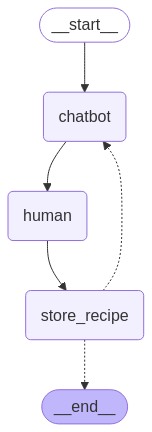

In [6]:
from IPython.display import Image, display

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [7]:
# Uncomment the .invoke() line to test the chatbot
config = {"recursion_limit": 100}
# state = chat_with_human_graph.invoke({"messages": []}, config)